In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import doctest
import copy

In [40]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Bicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$. Assume the wheelbase of the vehicle $L$ = 0.9 m

In [18]:
@test 
def bicycle_model(curr_pose, v, delta, dt=1.0):
    '''
    >>> bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
    (0.0, 0.0, 0.0) 
    >>> bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
    (1.0, 0.0, 1.11) 
    '''
    L = 0.9 #L = Wheelbase
    # write code to calculate next_pose
    # refer to the kinematic equations of a bicycle model
    x, y, theta = curr_pose
    x += v * np.cos(theta) * dt
    y += v * np.sin(theta) * dt
    theta += (v * np.tan(delta) / L) * dt
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return x, y, theta

Finding tests in bicycle_model
Trying:
    bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expecting:
    (0.0, 0.0, 0.0) 
**********************************************************************
File "__main__", line 6, in bicycle_model
Failed example:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expected:
    (0.0, 0.0, 0.0) 
Got:
    (0.0, 0.0, 0.0)
Trying:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expecting:
    (1.0, 0.0, 1.11) 
**********************************************************************
File "__main__", line 8, in bicycle_model
Failed example:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expected:
    (1.0, 0.0, 1.11) 
Got:
    (1.0, 0.0, 1.111111111111111)


In [5]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and delta values
v = 0.1 #1
delta = 0.0
curr_pose = pose
straight_trajectory.append(curr_pose)
for _ in range(steps):
  #instruction to take v, delta and compute new pose    
  new_pose = bicycle_model(curr_pose, v, delta)
  curr_pose = new_pose
  # store new pose
  straight_trajectory.append(curr_pose)

straight_trajectory = np.array(straight_trajectory)
    

In [6]:
#circle
circle_trajectory = []
pose = (0, 0, np.pi/2)
steps = 100
#fill in v and delta values
v = 0.1
delta = 0.523
curr_pose = pose
circle_trajectory.append(curr_pose)
for _ in range(steps):
    #instruction to take v, delta and compute new pose    
    new_pose = bicycle_model(curr_pose,v,delta)
    curr_pose = new_pose
    circle_trajectory.append(curr_pose)
   # store new pose
circle_trajectory = np.array(circle_trajectory)


In [7]:
### Plot straight and circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(circle_trajectory[:,0], circle_trajectory[:,1])
plt.show()


<IPython.core.display.Javascript object>

### Simulate Bicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\delta$. To make it even simpler, $\delta$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\delta = \delta_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\delta_c$?
* When should $\delta$ change from 0 and back?

In [10]:
v_c = 0.3 # m/s
delta_c = 0.5235 # rad/s
L = 0.9
#calculate time taken to finish a quarter turn (pi/4)
# unlike you would need to take into account v_c and L of the vehicle as well
t_turn = (np.pi/4) / (v_c * np.tan(delta_c) / L)
print("t_turn:",t_turn)
#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

# t_straight1, t_straight_2, t_straight3 = #Similarly for straight segments

# all_delta = [0]*t_straight1 + [delta_c]*t_turn + /
#         [0]*t_straight2 + [delta_c]*t_turn + /
#         [0]*t_straight3 + [-delta_c]*t_turn
# all_v = vc*np.ones_like(all_delta)

t_turn: 4.081979666908123


Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_delta

In [16]:
def get_open_loop_commands(route, v_c, delta_c):
  all_delta = []
  L = 0.9
  delta_lookup = {'straight':0.0, 'left':delta_c, 'right':-delta_c} 
  for maneouvre, distance in route:
    if(maneouvre == 'straight'):
      t = np.ceil(distance / v_c).astype('int')
      all_delta.extend([delta_lookup[maneouvre]] * t)
    else:
      omega = np.ceil((v_c * np.tan(np.deg2rad(delta_c))) / L) #Interpretation: For a steering angle of 
      #delta_c rad/sec, the entire vehicle turns by omega rad/sec
      t = np.ceil(np.deg2rad(distance) / omega).astype('int')
      all_delta.extend([delta_lookup[maneouvre]] * t)
  all_v = v_c * np.ones_like(all_delta)
  # print("all_v:",all_v)
  # print("all_delta:",all_delta)
  return all_v, all_delta

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $delta_c = \pi/12$

In [20]:
commands = [("straight",5),("right",90),("straight",6),("left",85)]
v_c = 1
delta = np.pi / 12
all_v, all_delta = get_open_loop_commands(commands,v_c,delta_c)

In [32]:
robot_trajectory = []
pose = (0, 0, np.pi/2)
curr_pose = pose
robot_trajectory.append(curr_pose)
for v, delta in zip(all_v, all_delta):
  pose = bicycle_model(curr_pose, v, delta)
  curr_pose = pose
  robot_trajectory.append(curr_pose)

robot_trajectory = np.array(robot_trajectory)
print(robot_trajectory[:,0])
    #instruction to take v, delta and compute new pose    
   # store new pose

[0.00000000e+00 6.12323400e-17 1.22464680e-16 1.83697020e-16
 2.44929360e-16 3.06161700e-16 3.67394040e-16 5.98280910e-01
 1.55706967e+00 2.51585842e+00 3.47464718e+00 4.43343593e+00
 5.39222469e+00 6.35101345e+00 7.30980220e+00 7.90808311e+00]


In [38]:
# plot robot trajectory
plt.figure()
plt.plot(robot_trajectory[:,0],robot_trajectory[:,1],'r+')
plt.grid()
plt.show()
#plt.plot( )

#show first and last robot positions with + markers
plt.plot(0, 0, 'r+', ms=10)
plt.show()


<IPython.core.display.Javascript object>

### Shape the turn
Let us try something cooler than before (though a bit tricky in open loop). Instead of boring circular arcs, change the steering angle so that the robot orientation changes as shown in the equation below

$\theta = (\theta_i - \theta_f) * (1 - 3x^2 + 2\theta^3) + \theta_f  \thinspace \vee x \in [0,1]$

First let us plot this

In [ ]:
def poly_turn(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    return (theta_i-theta_f) * (1 - 3 * x * x + 2 * (x**3)) + theta_f

How does a right turn look? 

In [ ]:
theta_dot = np.diff(poly_turn(np.pi/2, 0))
print(theta_dot)

[-0.05386819 -0.14436674 -0.20900856 -0.24779366 -0.26072202 -0.24779366
 -0.20900856 -0.14436674 -0.05386819]


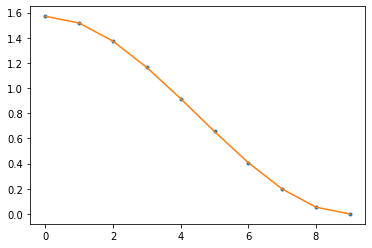

In [ ]:
plt.figure()
plt.plot(poly_turn(np.pi/2, 0),'.')
plt.plot(poly_turn(np.pi/2, 0))

Now plot a left turn (North to East)

In [ ]:
plt.figure()
plt.plot(poly_turn(),'.')
plt.plot(poly_turn())

How does $\theta$ change when we had constant $\delta$? Plot it

We know the rate of change of $\theta$ is proportional to $\delta$. Can you work out the sequence of $\delta$ to change $\theta$ as in the cubic polynomial shown above?